# Reti Neurali e Deep Learning
## Laboratorio: reti convolutive con Keras


### Introduzione


In questa sessione costruiremo una CNN con Keras ed eseguiremo l'apprentimento sul dataset Fashion-MNIST.

In [1]:
from base64 import decodebytes
print(decodebytes(b'RCdhY2NvcmRvLCBjb21pbmNpYW1vIQ==\n').decode('utf-8'))

D'accordo, cominciamo!


Installazione e importazione delle librerie software necessarie

In [3]:
!pip install tensorflow

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random

from pprint import pprint
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, minmax_scale
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization, Reshape

matplotlib.rcParams['figure.figsize'] = [10,10]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Dati

Caricamento del dataset usato per l'allenamento della rete neurale

4431872/4422102 [==============================] - 0s 0us/step
Caricato e normalizzato il dataset Fashion-MNIST.
Il training set e il test set sono composti rispettivamente da 60000 e 10000 esempi.
Ogni esempio è un'immagine 28x28 (784 dimensioni totali)
Sono possibili 10 output: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Ecco alcuni esempi:


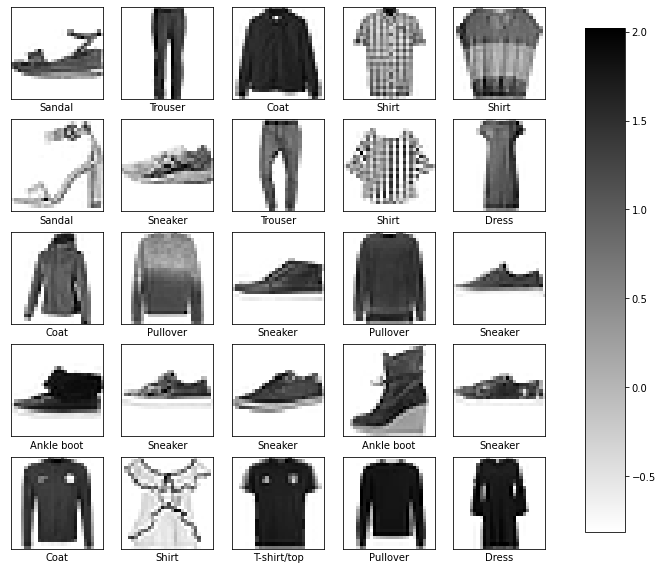

In [4]:
# Caricamento
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
y_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Normalizzazione
X = np.concatenate([X_train, X_test])
mean = np.average(X)
std = np.std(X)
# Applico una normalizzazione dei dati in modo da avere avg = 0 e stdev = 1 sia per l'insieme di train che per quello di test
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Analisi
print(f'Caricato e normalizzato il dataset Fashion-MNIST.')
print(f'Il training set e il test set sono composti rispettivamente da {X_train.shape[0]} e {X_test.shape[0]} esempi.')
print(f'Ogni esempio è un\'immagine {X_train.shape[1]}x{X_train.shape[2]} ({X_train[0].size} dimensioni totali)')
print(f'Sono possibili {len(y_names)} output: {str(y_names)}')

print('\nEcco alcuni esempi:')

fig = plt.figure(figsize=(11,10))
for i, (img, label) in enumerate(random.choices(list(zip(X_train, y_train)), k=25)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(y_names[label])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(cax=cbar_ax)
plt.show()

Visualizzazione dei dati su un piano cartesiano bidimensionale usando l'analisi delle componenti principali (PCA).

La PCA ha conservato il 46.80% dell'informazione contenuta nei dati.


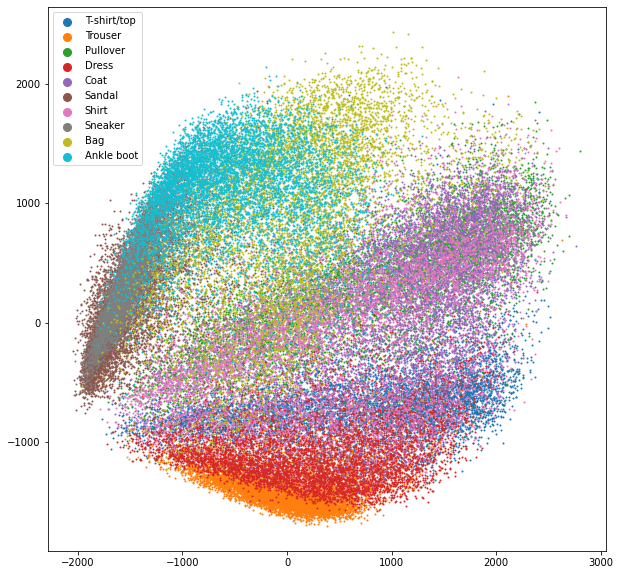

In [5]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.reshape(X.shape[0], -1))
print(f'La PCA ha conservato il {100 * sum(pca.explained_variance_ratio_):.2f}% dell\'informazione contenuta nei dati.')

y = np.concatenate([y_train, y_test])
for i, l in enumerate(y_names):
  j = np.where(y == i)
  X_plot = X_pca[j]
  plt.scatter(X_plot[:,0], X_plot[:,1], label=l, c=f'C{i}', s=1)
plt.legend(markerscale=8)
plt.show()

Possiamo notare come dalla PCA alcune classi siano molto sovrapposte tra di loro, per cui sappiamo che un sistema di autoapprendimento potrebbe confonderle tra di loro

### Architettura

Keras contiene, tra le altre cose, classi e funzioni che implementano:
*   Operazioni delle reti neurali (somme pesate, attivazioni...)
*   Calcolo delle derivate automatico
*   Algoritmo di retropropagazione dell'errore e suoi derivati (SGD, momentum, Adam...)

Non è quindi più necessario programmarli a manina, ma basterà definire la sequenza dei calcoli della nostra rete.

Costruiamo la nostra rete concatenando gli strati che ci servono:



In [6]:
model = Sequential([
    Reshape(target_shape=(28, 28, 1)),
    # Blocco convolutivo (Conv + ReLU + MaxPool)
    Conv2D(16, 3, strides=1, padding='valid', activation='relu'),
    # Ogni pixel viene coperto da una sola volta siccome stride = pool_size
    MaxPool2D(pool_size=2, strides=2, padding='valid'),
    BatchNormalization(),
    Conv2D(32, 3, strides=1, padding='valid', activation='relu'),
    MaxPool2D(pool_size=2, strides=2, padding='valid'),
    BatchNormalization(),

    # Trasforma l'output della convoluzione in un vettore di features (siccome questa e' la parte)
    # fully connected della rete (MLP)
    Flatten(),
    # Fully Connected (Dense + ReLU)
    Dense(256, activation='relu'),
    Dropout(0.2),
    # Fully Connected (Dense + ReLU)
    Dense(64, activation='relu'),
    Dropout(0.2),
    # Strato di output (Dense + Softmax)
    Dense(len(y_names), activation='softmax')
])


### Errore

Per problemi di classificazione possiamo usare come funzione di loss (misura dell'errore) l'[entropia incrociata](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a), che tende a dare risultati migliori di MSE:

$$
H_p(q) = -\sum^C_{c=1}q(y_c) \cdot log(p(y_c))
$$

### Apprendimento

Come già detto, gli algoritmi di apprendimento sono implementati da Keras, così come la procedura di early stopping:

In [7]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

...un momento, cosa significa [early stopping](https://towardsdatascience.com/early-stopping-a-cool-strategy-to-regularize-neural-networks-bfdeca6d722e)?

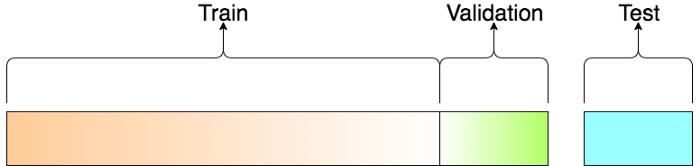

Definiamo alcuni **iperparametri**:
* eta: tasso di apprendimento o *learning rate*
* alpha: coefficiente per il momentum
* batch_size: numero di esempi su cui calcolare i gradienti
* epochs: numero massimo di epoche per apprendimento. Un'epoca è un singolo utilizzo da parte della rete di ogni elemento del dataset per l'apprendimento
* patience: numero di epoche senza miglioramento delle prestazioni dopo le quali l'allenamento è fermato


In [8]:
eta = 0.0005
alpha = 0.9
batch_size = 256

epochs = 100  # Numero alto, per rendere più probabile l'early stopping
patience = 20

Il codice per l'allenamento vero e proprio è questo:

In [9]:
# Parametri per l'apprendimento
model.compile(optimizer=SGD(learning_rate=eta, momentum=alpha),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Apprendimento (il criterio di terminazione sarà early stopping o il numero di epoche)
history = model.fit(X_train, y_train, verbose=1,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True)],
                    validation_split=0.1)

# Tengo memoria degli errori
errors = []

print('\nDone!')

train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'\nTraining error is {train_loss:.4f}')
print(f'Training accuracy is {100*train_accuracy:.2f}%')

# best_epoch = np.argmin(history.history['val_loss'])
best_epoch = np.argmax(history.history['val_accuracy'])
print(f'\nValidation error is {history.history["val_loss"][best_epoch]:.4f}')
print(f'Validation accuracy is {100*history.history["val_accuracy"][best_epoch]:.2f}%')


Epoch 1/100
211/211 [==============================] - 14s 8ms/step - loss: 1.2863 - accuracy: 0.5580 - val_loss: 1.1870 - val_accuracy: 0.6950
Epoch 2/100
211/211 [==============================] - 1s 6ms/step - loss: 0.7806 - accuracy: 0.7227 - val_loss: 0.6322 - val_accuracy: 0.7793
Epoch 3/100
211/211 [==============================] - 1s 6ms/step - loss: 0.6849 - accuracy: 0.7530 - val_loss: 0.5369 - val_accuracy: 0.7988
Epoch 4/100
211/211 [==============================] - 1s 6ms/step - loss: 0.6272 - accuracy: 0.7720 - val_loss: 0.4997 - val_accuracy: 0.8165
Epoch 5/100
211/211 [==============================] - 1s 6ms/step - loss: 0.5857 - accuracy: 0.7865 - val_loss: 0.4706 - val_accuracy: 0.8225
Epoch 6/100
211/211 [==============================] - 1s 6ms/step - loss: 0.5545 - accuracy: 0.7994 - val_loss: 0.4513 - val_accuracy: 0.8347
Epoch 7/100
211/211 [==============================] - 1s 6ms/step - loss: 0.5302 - accuracy: 0.8086 - val_loss: 0.4324 - val_accuracy: 0.840

Dai dati possiamo vedere come effettivamente il modello abbia fatto leggermente overfitting (accuracy e' piu' grande in training rispetto a quella in validation)

### Valutazione

Visualizziamo come è evoluto l'errore durante l'apprendimento, e quale percentuale di successo ha la rete su dati mai visti.

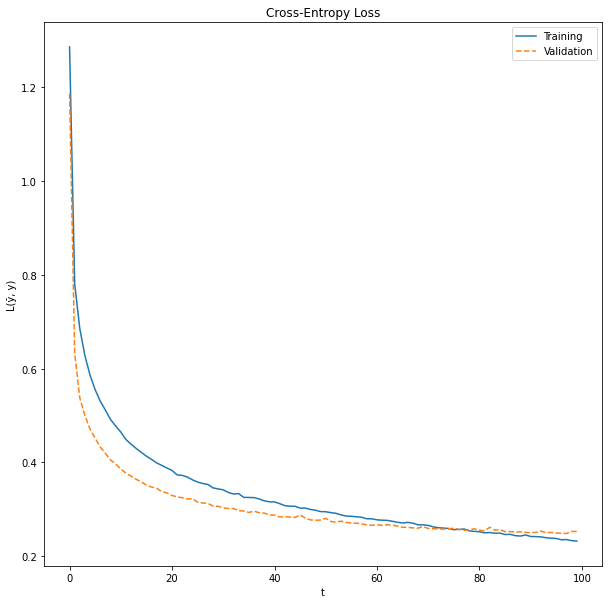

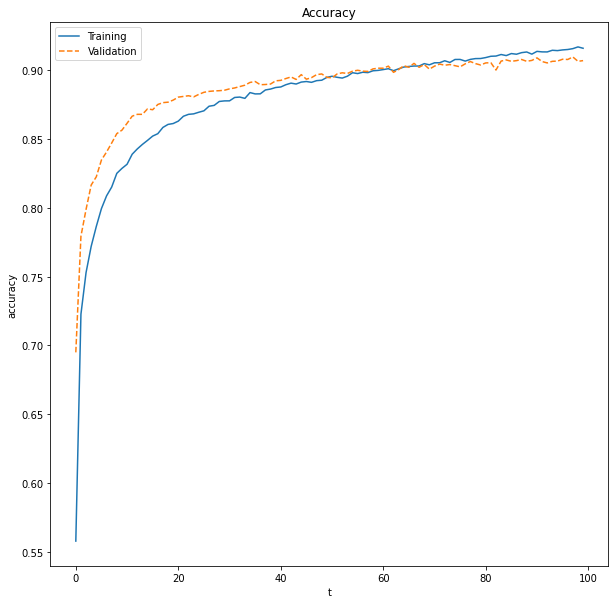

Test accuracy is 90.12%


In [10]:
plt.title('Cross-Entropy Loss')
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation', ls='--')
plt.xlabel('t')
plt.ylabel('L(ỹ, y)')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation', ls='--')
plt.xlabel('t')
plt.ylabel('accuracy')
plt.legend()
plt.show()

_, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy is {100*test_accuracy:.2f}%')

I risultati sono soddisfacenti?

Prova a variare, nel modello (con l'aiuto delle [API](https://www.tensorflow.org/api_docs/python/tf/keras/layers)):
* il numero di blocchi convolutivi
* nelle convoluzioni e negli strati di pooling
  * kernel size
  * padding
  * stride
* il numero di strati completamente connessi (`Dense`) e, in ognuno, il numero di neuroni
* la presenza di strati `Dropout`
* la presenza di strati `BatchNormalization`

Nell'apprendimento:
* il numero massimo di epoche
* il numero di epoche in cui "pazientare"
* la dimensione dei mini-batch
* l'algoritmo di apprendimento (per provare Adam, sostituire `SGD(...)` con `Adam(learning_rate=eta)`)
* il valore del tasso di apprendimento, eta (solitamente si usano potenze negative di 10)
* il coefficiente del momentum, alfa (solo per SGD, deve essere compreso tra 0 e 1)

**Con questo dataset e usando una rete convolutiva relativamente semplice, l'accuracy potrà superare senza problemi il 90%.**